### Stronger temperature–moisture couplings exacerbate the impact of climate warming on global crop yields (Lesk et al. 2021)
### https://www.nature.com/articles/s43016-021-00341-6
### Future Projections (Figs 4-6, SI Figs 3-5)

Steps:
1) access, pre-process, and save climate model monthly outputs
2) compute growing season means and save netcdfs
3) Detrend T, P, and ET; compute interannual T-P and T-ET correlation; regrid to 0.5deg (climate models have various resolutions)
4) compute future correlation deltas (fut - hist) and regrid to project resolution
5) project future yield impacts (delY and deldelY)
6) plot Fig's 4-5
7) compute model agreement on sign, plot fig 6

Note that you will modify directories to match your local structure
***

### step 1: gather climate model outputs using google cloud api

In [1]:
import xarray as xr
import intake
%matplotlib inline
import pandas as pd 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from netCDF4 import Dataset
import pickle
import gzip
import glob
import scipy
import os
import warnings
import matplotlib as mpl


#open whole catalogue of cmip6
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df

C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


activity_id institution_id   source_id experiment_id member_id  \
0        AerChemMIP        AS-RCEC     TaiESM1       histSST  r1i1p1f1   
1        AerChemMIP            BCC    BCC-ESM1       histSST  r1i1p1f1   
2        AerChemMIP            BCC    BCC-ESM1       histSST  r1i1p1f1   
3        AerChemMIP            BCC    BCC-ESM1       histSST  r1i1p1f1   
4        AerChemMIP            BCC    BCC-ESM1       histSST  r1i1p1f1   
5        AerChemMIP            BCC    BCC-ESM1       histSST  r1i1p1f1   
6        AerChemMIP            BCC    BCC-ESM1       histSST  r1i1p1f1   
7        AerChemMIP            BCC    BCC-ESM1       histSST  r1i1p1f1   
8        AerChemMIP            BCC    BCC-ESM1       histSST  r1i1p1f1   
9        AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
10       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
11       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
12       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
13       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
14       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
15       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
16       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
17       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
18       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
19       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
20       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
21       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
22       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
23       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
24       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
25       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
26       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
27       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
28       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
29       AerChemMIP            BCC    BCC-ESM1    piClim-CH4  r1i1p1f1   
...             ...            ...         ...           ...       ...   
314899  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314900  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314901  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314902  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314903  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314904  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314905  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314906  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314907  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314908  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314909  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314910  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314911  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314912  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314913  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314914  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314915  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314916  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314917  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314918  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314919  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314920  ScenarioMIP             UA  MCM-UA-1-0        ssp585  r1i1p1f2   
314921  Scen

In [160]:
#refine query to get monthly evapotranspiration, historical. can modify this 'historical' to 'scenarioMIP' for future runs, and modify variable_id to get precip and temp
df_ta = df.query("activity_id == 'CMIP' & table_id == 'Amon' & variable_id == 'evspsbl' & experiment_id == 'historical'")

#show available models from this query
mods = df_ta.source_id.unique()
mods

array(['BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'FGOALS-g3', 'CanESM5',
       'CNRM-CM6-1', 'CNRM-ESM2-1', 'E3SM-1-0', 'EC-Earth3-Veg',
       'EC-Earth3', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6',
       'HadGEM3-GC31-LL', 'UKESM1-0-LL', 'MRI-ESM2-0', 'GISS-E2-1-G-CC',
       'GISS-E2-1-G', 'GISS-E2-1-H', 'CESM2-FV2', 'CESM2-WACCM-FV2',
       'CESM2-WACCM', 'CESM2', 'NorCPM1', 'GFDL-CM4', 'GFDL-ESM4', 'NESM3',
       'SAM0-UNICON', 'MCM-UA-1-0'], dtype=object)

In [161]:
#this alternative code gets the models available from a directory on your disk, if you already have modle outputs downloaded. 
def gtMd(f):
    arg='Amon_'
    substr=f[f.find(arg)+len(arg):]
    return substr[:substr.find('_')]

scen = 'historical'
var='evspsbl'

fet=glob.glob('E:\\data\\cmip6\\processed\\ssp245\\evspsbl\\*.nc')


futet_mod = [gtMd(f) for f in fet]
mods = futet_mod
mods

['BCC-CSM2-MR',
 'CanESM5',
 'CESM2-WACCM',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'FGOALS-g3',
 'GFDL-CM4',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MRI-ESM2-0',
 'UKESM1-0-LL']

In [129]:
#set hist and future time bounds
time_bounds_hist = ['1960-01-15','2010-12-16']
time_bounds_fut = ['2050-01-15','2100-12-16']


In [164]:
## this accesses, pre-processes, and downloads model outputs

# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

#loop over the models you want
for model in mods[-2:]:
    
    #skip problematic models?
    #if model == 'CNRM-CM6-1': continue
        
    print('processing ' + model +'...')
    df_mod = df_ta[df_ta.source_id == model]
    
    # get the path to a specific zarr store (the first one from the dataframe above)
    zstore = df_mod.zstore.values[0]
    
    # create a mutable-mapping-style interface to the store
    mapper = gcs.get_mapper(zstore)
    
    # open it using xarray and zarr
    ds = xr.open_zarr(mapper, consolidated=True)
    
    # select time
    ds = ds.sel(time=slice(time_bounds_hist[0],time_bounds_hist[1]))
    
    # orient lons
    try:
        ds = ds.roll(lon=int(ds.lon.shape[0]/2))
    except:
        ds = ds.roll(longitude=int(ds.longitude.shape[0]/2))
        
    #save to disk
    print('saving ' + model +'...')
    fname = var+'_Amon_' +model+'_'+scen+'_'+ds.parent_variant_label+'_'+ds.grid_label+'_1961-2010.nc'
    dirname = 'E:\\data\\cmip6\\' + scen + '\\' + var + '\\'
    
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
    
    ds.to_netcdf(dirname + fname)

processing MRI-ESM2-0...


C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.


saving MRI-ESM2-0...
processing UKESM1-0-LL...


C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.


saving UKESM1-0-LL...


In [163]:
nc_fid.close()

***
### Step 2: Compute and save growing season averages from monthly model outputs

In [6]:

#params for growing season averaging:
rayDir = #raw yield data available from Deepak Ray, or freely use the yield sensitivities included in this repository
calDir = #Sacks et al. 2010 crop calendars, including planting and harvest mean dates

years = range(2051,2101)

crops = ['Maize','Wheat','Rice','Soybean']


In [3]:
#get models from dir 
def gtMd(f):
    arg='Amon_'
    substr=f[f.find(arg)+len(arg):]
    return substr[:substr.find('_')]

scen = 'historical'
var='tas'

fet=glob.glob('E:\\data\\cmip6\\historical\\tas\\*.nc')


futet_mod = [gtMd(f) for f in fet]
mods = futet_mod
mods

['BCC-CSM2-MR',
 'CanESM5',
 'CESM2-WACCM',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'FGOALS-g3',
 'GFDL-CM4',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MRI-ESM2-0',
 'UKESM1-0-LL']

In [7]:
## compute seasonal means: for a given variable/scenario, loop over models and compute seasonal mean and save files (model/var/scen)
scen='ssp245'
var='tas'
saveDir = #set output dir

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)
    
#problematic models to skip
skip_mods = []

try:
    ds.close()
    nc_fid.close()
except: print('')

for model in mods:
    
    #skip specified models
    if model in skip_mods: continue
        
    #open model
    print('opening model: ' + model + ' for ' + var + '...' )
    f=glob.glob('E:\\data\\cmip6\\' + scen  + '\\' + var + '\\*' + model + '*.nc')
    nc_fid=Dataset(f[0])
    
    if len(nc_fid['time'][:])/12 != 51: 
        skip_mods.append(model)
        continue
    
    #grab lon/lat from model
    modLon = nc_fid['lon'][:] 
    modLon[:int(len(modLon)/2)]=modLon[:int(len(modLon)/2)]-360  # will need a lon mapper?
    modLat = nc_fid['lat'][:]

    #open and set up .nc to write to
    ds = Dataset(saveDir + var + '_' + f[0][f[0].find('\\'+var):][9:-3]  + '_wrms_gsAvg.nc','w')
    ds.createDimension('lon',size=modLon.shape[0])
    ds.createDimension('lat',size=modLat.shape[0])
    ds.createDimension('time',size=len(years))
    ds.createVariable('lon',modLon.dtype,('lon'))
    ds.createVariable('lat',modLat.dtype,('lat'))
    ds.createVariable('time','int',('time'))
    ds['lat'][:] = modLat[:]
    ds['lon'][:] = modLon[:]
    ds['time'][:] = np.array([y for y in years],dtype='int')[:]

    #grab et variable
    et = nc_fid[var][:]
    etrs = np.reshape(et,(len(years)+1,12,len(modLat),len(modLon)))

    for c in crops:
        print('averaging growing seasons for ' + c + '...')

        #open crop calendar
        cal = xr.open_dataset(calDir + c + '_cropCal.nc')

        #regrid crop calendar to model resolution
        calRegrid=cal.interp(longitude=modLon,latitude=modLat)

        #compute seasonal mean ET
        et_season = np.nan*np.empty((len(years),nc_fid['lat'].shape[0],nc_fid['lon'].shape[0]))
        
        #loop over space and average the variable
        for i in range(nc_fid['lat'].shape[0]):
            for j in range(nc_fid['lon'].shape[0]):

                if np.isnan(calRegrid.harvest[i,j]): continue
                if np.ma.is_masked(calRegrid.harvest[i,j]): continue
                if modLat[i]<-60: continue
                
                #this switch handles harvest dates BEFORE planting dates, i.e. crop seasons spanning the new year
                if var == 'pr':
                    if calRegrid.harvest[i,j]<calRegrid.plant[i,j]:
                        et_season[:,i,j] = np.sum( np.hstack( (etrs[:-1,int(calRegrid.plant[i,j]):,i,j], etrs[1:,:int(calRegrid.harvest[i,j])+1,i,j] )), axis=1)
                    else:
                        et_season[:,i,j] = np.sum(etrs[1:,int(calRegrid.plant[i,j]):int(calRegrid.harvest[i,j])+1,i,j],axis=1)

                else:
                    if calRegrid.harvest[i,j]<calRegrid.plant[i,j]:
                        et_season[:,i,j] = np.mean( np.hstack( (etrs[:-1,int(calRegrid.plant[i,j]):,i,j], etrs[1:,:int(calRegrid.harvest[i,j])+1,i,j] )), axis=1)
                    else:
                        et_season[:,i,j] = np.mean(etrs[1:,int(calRegrid.plant[i,j]):int(calRegrid.harvest[i,j])+1,i,j],axis=1)

        #write crop 
        print('saving ' + c + '...')
        ds.createVariable(var + '_'+c,nc_fid['lat'].dtype,('time','lat','lon'))
        ds[var+'_'+c][:] = et_season

    ds.close()

print(skip_mods)

opening model: FGOALS-g3 for tas...
averaging growing seasons for Maize...
saving Maize...
averaging growing seasons for Wheat...
saving Wheat...
averaging growing seasons for Rice...
saving Rice...
averaging growing seasons for Soybean...
saving Soybean...
[]


***
### Plot and troubleshoot individual models..

In [2]:
#check downloaded files
fp=glob.glob('E:\\data\\cmip6\\processed\\ssp245\\pr\\*.nc')
ft=glob.glob('E:\\data\\cmip6\\processed\\historical\\tas\\*.nc')
fet=glob.glob('E:\\data\\cmip6\\processed\\ssp245\\evspsbl\\*.nc')
fet85=glob.glob('E:\\data\\cmip6\\processed\\ssp585\\evspsbl\\*.nc')

fet85

['E:\\data\\cmip6\\processed\\ssp585\\evspsbl\\evspsbl_Amon_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_2050-2100_wrms_gsAvg.nc',
 'E:\\data\\cmip6\\processed\\ssp585\\evspsbl\\evspsbl_Amon_CAMS-CSM1-0_ssp585_r1i1p1f1_gn_2050-2100_wrms_gsAvg.nc',
 'E:\\data\\cmip6\\processed\\ssp585\\evspsbl\\evspsbl_Amon_CanESM5_ssp585_r10i1p1f1_gn_2050-2100_wrms_gsAvg.nc',
 'E:\\data\\cmip6\\processed\\ssp585\\evspsbl\\evspsbl_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_2050-2100_wrms_gsAvg.nc',
 'E:\\data\\cmip6\\processed\\ssp585\\evspsbl\\evspsbl_Amon_CNRM-CM6-1_ssp585_r1i1p1f2_gr_2050-2100_wrms_gsAvg.nc',
 'E:\\data\\cmip6\\processed\\ssp585\\evspsbl\\evspsbl_Amon_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_2050-2100_wrms_gsAvg.nc',
 'E:\\data\\cmip6\\processed\\ssp585\\evspsbl\\evspsbl_Amon_FGOALS-g3_ssp585_r1i1p1f1_gn_2050-2100_wrms_gsAvg.nc',
 'E:\\data\\cmip6\\processed\\ssp585\\evspsbl\\evspsbl_Amon_GFDL-CM4_ssp585_r1i1p1f1_gr1_2050-2100_wrms_gsAvg.nc',
 'E:\\data\\cmip6\\processed\\ssp585\\evspsbl\\evspsbl_Amon_GFDL-ESM4_ss


missing models on Google cloud: can get ACCESS models from ESGF API, not on Google cloud. CAMS_CSM1-0 missing for et for ssp245.

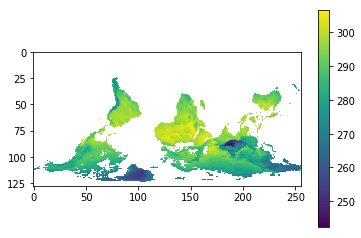

In [14]:
#check an et file
var='tas'
saveDir = 'E:\\data\\cmip6\\processed\\historical\\' + var + '\\'

f=glob.glob(saveDir +  '*_wrms_gsAvg*.nc')

ds=xr.open_dataset(f[4])
plt.imshow(ds.sel(time=2051).tas_Wheat.values);plt.colorbar()

In [12]:
#check a raw file directly from the repository for troubleshooting
gcs = gcsfs.GCSFileSystem(token='anon')
mapper = gcs.get_mapper(df_ta['zstore'].values[0])
ds = xr.open_zarr(mapper, consolidated=True)
ds.pr


['CNRM-ESM2-1', 'FGOALS-g3']

### map historical coupling correlations from models

C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\mpl_toolkits\basemap\__init__.py:3360: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\mpl_toolkits\basemap\__init__.py:3399: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


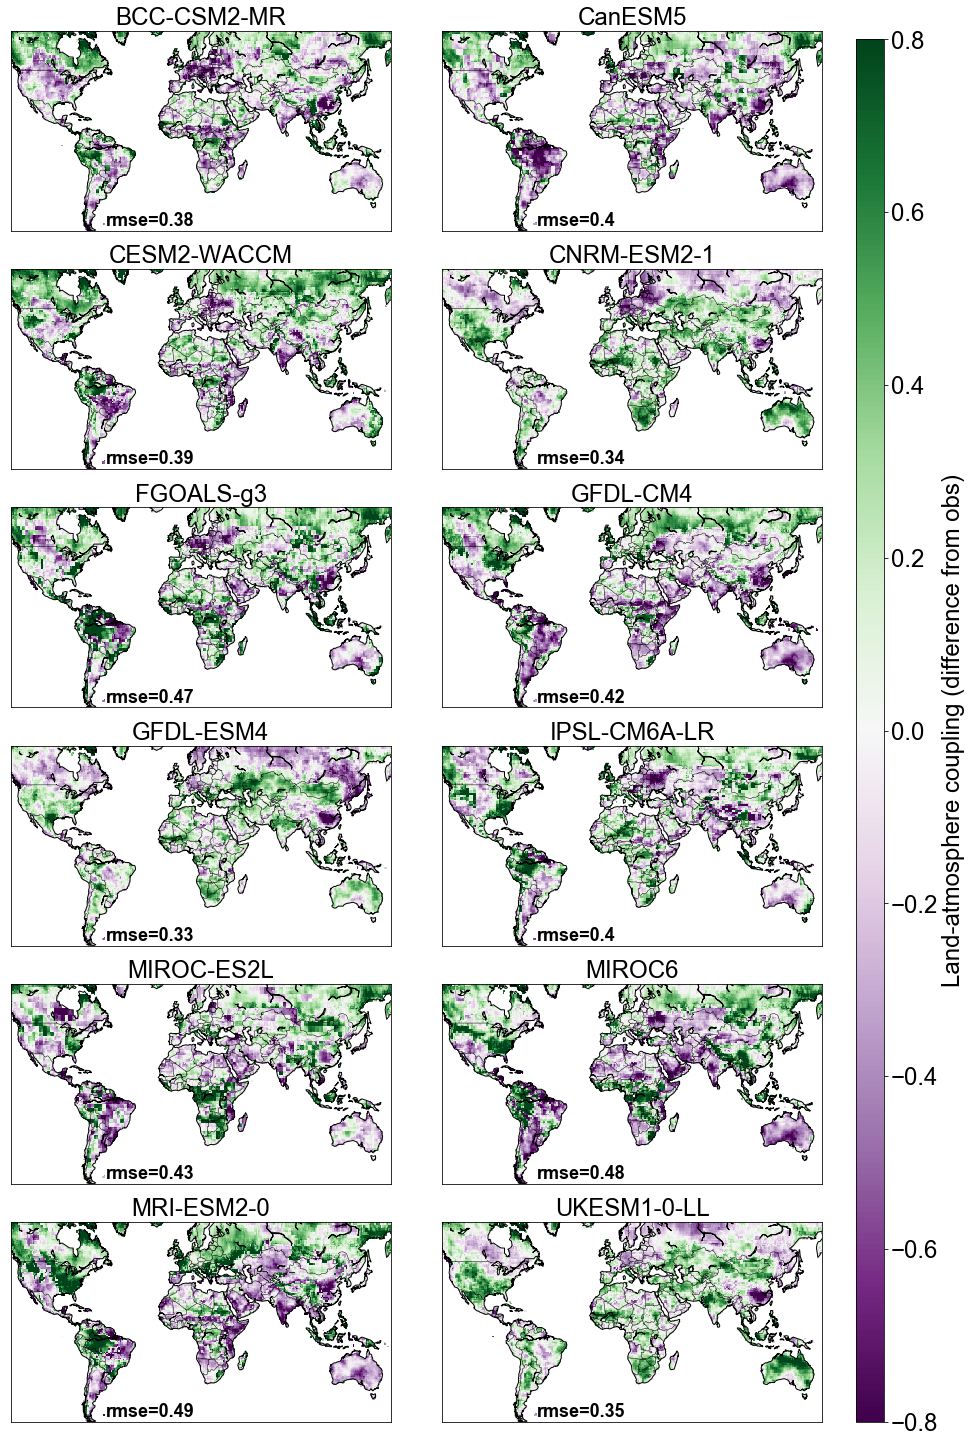

In [6]:
from mpl_toolkits.basemap import Basemap
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

sacksDir = '...\\data\\SacksData\\0.5d\\'
sacks = Dataset(sacksDir + '\\Maize.crop.calendar.fill.nc','r')    
lon = sacks['longitude'][:]
lat = sacks['latitude'][:]
lons = lon
lats = lat
lonGrid,latGrid=np.meshgrid(lons,lats)

models=['BCC-CSM2-MR',
 'CanESM5',
 'CESM2-WACCM',
 'CNRM-ESM2-1',
 'FGOALS-g3',
 'GFDL-CM4',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MRI-ESM2-0',
 'UKESM1-0-LL']

varname = 'rtet'
c='Maize'

f = gzip.open('E:\\data\\compimp_processed\\partial_corr_t-p_wrms_1961-2008.dat', 'rb')
par_corr = pickle.load(f)
f.close()


if varname == 'rtp': 
    cmap='RdYlBu'
    f = gzip.open('E:\\data\\compimp_processed\\partial_corr_t-p_wrms_1961-2008.dat', 'rb')
    obs = pickle.load(f)
    obs = obs[c]['r(t,p)']
    f.close()
    lab='Circulation coupling (difference from obs)'
    
elif varname == 'rtet':
    cmap='PRGn'
    f = gzip.open('E:\\data\\compimp_processed\\gldas_correl_maps\\r-temp-et_wrms_1961-2008.dat', 'rb')
    obs = pickle.load(f)
    obs = obs[c]
    f.close()
    lab='Land-atmosphere coupling (difference from obs)'

fig,axs = plt.subplots(6,2)
fig.set_size_inches(13,20)

for i,ax in enumerate(axs.reshape(-1)):
    
    f=gzip.open('E:\\data\\cmip6\\processed\\historical\\correl_maps\\'+models[i]+'_historical_'+varname+'_2050-2100.dat','rb')
    var=pickle.load(f)
    f.close()

    f=glob.glob('E:\\data\\cmip6\\historical\\tas\\*' + models[i] + '*.nc')
    nc_fid=Dataset(f[0])
    modLon = nc_fid['lon'][:] 
    modLon[:int(len(modLon)/2)]=modLon[:int(len(modLon)/2)]-360
    modLat = nc_fid['lat'][:]

    #build delta correlation array and regrid
    rds = xr.DataArray(data=(var[c]['r(t,et)']),dims=('lat','lon'),coords={'lat':modLat,'lon':modLon})
    rds=rds.interp(lon=lon,lat=lat,method='nearest')    
    
    m = Basemap(projection='merc',llcrnrlat=-55,urcrnrlat=65,llcrnrlon=-130,urcrnrlon=160,ax=ax)
    map=m.pcolor(lonGrid,latGrid,rds-obs,cmap=cmap,latlon=True,vmin=-0.8,vmax=0.8,ax=ax) 
    m.drawcoastlines();m.drawcountries();ax.set_title(models[i],fontsize=24)
    
    dev = rds-obs
    dev = dev.values
    dev[np.isnan(par_corr[c]['r(t,p)'])] = np.nan
    rmse = np.sqrt(np.nanmean(dev**2))
    ax.text(0.25,0.025,'rmse='+str(np.round(rmse,decimals=2)),transform=ax.transAxes,fontsize=18,fontweight='bold')
    
plt.tight_layout()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.95, 0.01, 0.03, 0.96])
cb=fig.colorbar(map, cax=cbar_ax)
cb.ax.tick_params(labelsize=24)
cb.set_label(lab,fontsize=24)
    

    
        

### Plot ensemble mean bias in couplings SI Fig. 5

C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\mpl_toolkits\basemap\__init__.py:3360: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\mpl_toolkits\basemap\__init__.py:3399: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


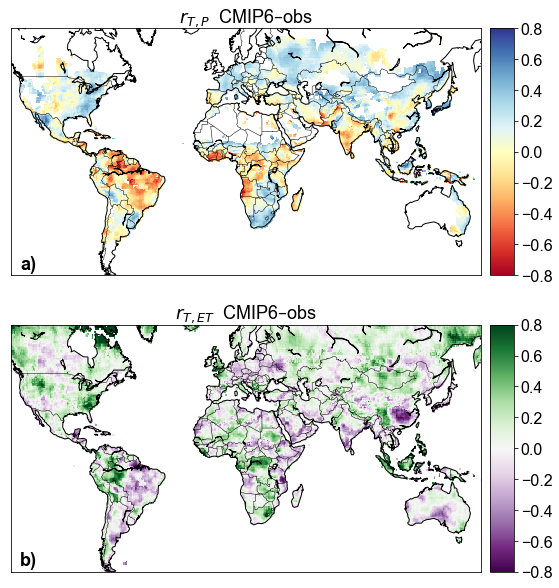

In [36]:
varnames = ['rtp','rtet']
c='Maize'
let=['a)','b)']
fig,axs = plt.subplots(2,1,figsize=(10,10))

for i,varname in enumerate(varnames):
    
    if varname == 'rtp': 
        k='r(t,p)'
        t=r'$r_{T,P}$'
        cmap='RdYlBu'
        f = gzip.open('E:\\data\\compimp_processed\\partial_corr_t-p_wrms_1961-2008.dat', 'rb')
        obs = pickle.load(f)
        obs = obs[c]['r(t,p)']
        #msk = np.isnan(obs)
        f.close()
        lab='Circulation coupling (difference from obs)'

    elif varname == 'rtet':
        k='r(t,et)'
        t=r'$r_{T,ET}$'
        cmap='PRGn'
        f = gzip.open('E:\\data\\compimp_processed\\gldas_correl_maps\\r-temp-et_wrms_1961-2008.dat', 'rb')
        obs = pickle.load(f)
        obs = obs[c]
        #obs[msk] = np.nan
        f.close()
        lab='Land-atmosphere coupling (difference from obs)'

    hist = np.empty((360,720,len(models)))
    for m in range(len(models)):

        f=gzip.open('E:\\data\\cmip6\\processed\\historical\\correl_maps\\'+models[m]+'_historical_'+varname+'_2050-2100.dat','rb')
        var=pickle.load(f)
        f.close()

        f=glob.glob('E:\\data\\cmip6\\historical\\tas\\*' + models[m] + '*.nc')
        nc_fid=Dataset(f[0])
        modLon = nc_fid['lon'][:] 
        modLon[:int(len(modLon)/2)]=modLon[:int(len(modLon)/2)]-360
        modLat = nc_fid['lat'][:]

        #build delta correlation array and regrid
        rds = xr.DataArray(data=(var[c][k]),dims=('lat','lon'),coords={'lat':modLat,'lon':modLon})
        rds=rds.interp(lon=lon,lat=lat,method='nearest')   

        hist[:,:,m] = rds.values

    rmse = np.sqrt(np.nanmean((np.nanmean(hist,axis=2)-obs)**2))
    
    ax=axs[i]
    m = Basemap(projection='merc',llcrnrlat=-55,urcrnrlat=65,llcrnrlon=-130,urcrnrlon=160,ax=ax)
    map=m.pcolor(lonGrid,latGrid,np.nanmean(hist,axis=2)-obs,cmap=cmap,latlon=True,vmin=-0.8,vmax=0.8,ax=ax) 
    m.drawcoastlines();m.drawcountries();
    cb=m.colorbar(map,ax=ax)
    cb.ax.tick_params(labelsize=16)
    ax.set_title(t + '  CMIP6–obs',fontsize=18)
    ax.text(0.02,0.025,let[i],transform=ax.transAxes,fontsize=18,fontweight='bold')    
    #ax.text(0.25,0.025,'rmse = ' + str(np.round(rmse,decimals=2)),transform=ax.transAxes,fontsize=18,fontweight='bold')    


### Step 3: Detrend T, P, and ET; compute interannual correlation; regrid to 0.5deg; lump crops into single correl dict

In [3]:
### SSA detrending

import scipy.stats
import pandas as pd 

class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
        
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
   

In [33]:
import time

crops = ['Maize','Wheat','Rice','Soybean']

def dtrd(d):
    if np.any(np.isnan(d)): return np.nan*np.empty(d.shape[0])
    ssa = SSA(d,10)
    return d - ssa.components_to_df()['F0'].values

def corp(d1,d2):
    if np.any(np.isnan(d1)): return (np.nan,np.nan)
    return scipy.stats.pearsonr(d1,d2)

def gtMd(f):
    arg='Amon_'
    substr=f[f.find(arg)+len(arg):]
    return substr[:substr.find('_')]

scen = 'ssp245'

var='evspsbl'
fet=glob.glob('E:\\data\\cmip6\\processed\\' + scen  + '\\' + var + '\\*.nc')


models = [gtMd(f) for f in fet]
models

['BCC-CSM2-MR',
 'CanESM5',
 'CESM2-WACCM',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'FGOALS-g3',
 'GFDL-CM4',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MRI-ESM2-0',
 'UKESM1-0-LL']

In [10]:
for mod in mods:

    print(mod + scen)

    t0 = time.perf_counter()

    var='tas'
    f=glob.glob('E:\\data\\cmip6\\processed\\' + scen  + '\\' + var + '\\*' + mod + '*.nc')
    nc_t=Dataset(f[0])

    var='pr'
    f=glob.glob('E:\\data\\cmip6\\processed\\' + scen  + '\\' + var + '\\*' + mod + '*.nc')
    nc_p=Dataset(f[0])

    var='evspsbl'
    f=glob.glob('E:\\data\\cmip6\\processed\\' + scen  + '\\' + var + '\\*' + mod + '*.nc')
    nc_et=Dataset(f[0])

    rtet = {}
    rtp = {}

    for c in crops:

        rtet[c] = {}
        rtp[c] = {}

        print('processing '+c+'...')
        et=nc_et['evspsbl_'+c][:]
        p=nc_p['pr_'+c][:]
        t=nc_t['tas_'+c][:]

        tdetrend = np.nan*np.empty_like(t)
        pdetrend = np.nan*np.empty_like(p)
        etdetrend = np.nan*np.empty_like(et)

        print('detrending...')
        tdetrend=np.reshape([dtrd(t[:,i,j]) for i in range(t.shape[1]) for j in range(t.shape[2])],t.shape)
        pdetrend=np.reshape([dtrd(p[:,i,j]) for i in range(p.shape[1]) for j in range(p.shape[2])],t.shape)
        etdetrend=np.reshape([dtrd(et[:,i,j]) for i in range(et.shape[1]) for j in range(et.shape[2])],t.shape)

        print('computing correlation...')
        cortet = np.array([corp(t[:,i,j],et[:,i,j]) for i in range(et.shape[1]) for j in range(et.shape[2])])
        cortp = np.array([corp(t[:,i,j],p[:,i,j]) for i in range(et.shape[1]) for j in range(et.shape[2])])

        rtet[c]['r(t,et)'] = np.reshape(cortet[:,0],(et.shape[1],et.shape[2]))
        rtet[c]['p(t,et)'] = np.reshape(cortet[:,1],(et.shape[1],et.shape[2]))

        rtp[c]['r(t,p)'] = np.reshape(cortp[:,0],(et.shape[1],et.shape[2]))
        rtp[c]['p(t,p)'] = np.reshape(cortp[:,1],(et.shape[1],et.shape[2]))

    print('saving maps...')
    f=gzip.open('E:\\data\\cmip6\\processed\\'+scen+'\\correl_maps\\'+mod+'_'+scen +'_rtet_2050-2100.dat','wb')
    pickle.dump(rtet,f)
    f.close()

    f=gzip.open('E:\\data\\cmip6\\processed\\'+scen+'\\correl_maps\\'+mod+'_'+scen +'_rtp_2050-2100.dat','wb')
    pickle.dump(rtp,f)
    f.close()

    print( 'model ' + mod + ' took: ' + str((time.perf_counter()-t0)/60) + ' minutes')



FGOALS-g3ssp245
processing Maize...
detrending...
computing correlation...
processing Wheat...
detrending...
computing correlation...
processing Rice...
detrending...
computing correlation...
processing Soybean...
detrending...
computing correlation...
saving maps...
model FGOALS-g3 took: 5.10883201799055 minutes


***
### examine model rtet/rtp 

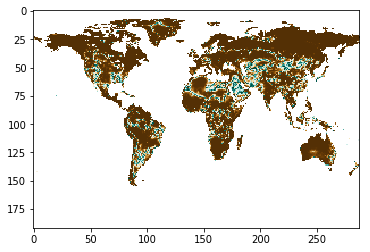

In [169]:
plt.imshow(np.flipud(ptet),cmap='BrBG',vmin=0,vmax=1)

***
### Step 4: compute future correlation deltas (fut - hist) and regrid to project resolution


In [46]:
models=['BCC-CSM2-MR',
 'CanESM5',
 'CESM2-WACCM',
 'CNRM-ESM2-1',
 'FGOALS-g3',
 'GFDL-CM4',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MRI-ESM2-0',
 'UKESM1-0-LL']

#'CAMS-CSM1-0','CNRM-CM6-1', 'MPI-ESM1-2-HR',

scen = 'ssp245'


In [47]:
### gather deltas in couplings
calDir = 'C:\\Users\\HAL 9000\\Documents\\research\\concurrent\\data\\cropCals\\'
cal = xr.open_dataset(calDir +'Maize_cropCal.nc')

crops = ['Maize','Wheat','Rice','Soybean']
print(scen)

deltaRtet = {}
deltaRtp = {}

for c in crops:
    print('computing correlation deltas for all models, scenario = ' + scen + ' ...')
    deltaRtet[c] = np.nan*np.empty((360,720,len(models)))
    deltaRtp[c] = np.nan*np.empty((360,720,len(models)))
    print(c)
    for m,mod in enumerate(models):

        #load correl maps hist and future
        f=gzip.open('E:\\data\\cmip6\\processed\\historical\\correl_maps\\'+mod+'_historical_rtet_2050-2100.dat','rb')
        rtet_hist=pickle.load(f)
        f.close()

        f=gzip.open('E:\\data\\cmip6\\processed\\historical\\correl_maps\\'+mod+'_historical_rtp_2050-2100.dat','rb')
        rtp_hist = pickle.load(f)
        f.close()

        f=gzip.open('E:\\data\\cmip6\\processed\\'+scen+'\\correl_maps\\'+mod+'_'+scen +'_rtet_2050-2100.dat','rb')
        rtet_fut = pickle.load(f)
        f.close()

        f=gzip.open('E:\\data\\cmip6\\processed\\'+scen+'\\correl_maps\\'+mod+'_'+scen +'_rtp_2050-2100.dat','rb')
        rtp_fut = pickle.load(f)
        f.close()

        #get model lon/lat
        f=glob.glob('E:\\data\\cmip6\\' + scen  + '\\tas\\*' + mod + '*.nc')
        nc_fid=Dataset(f[0])
        modLon = nc_fid['lon'][:] 
        modLon[:int(len(modLon)/2)]=modLon[:int(len(modLon)/2)]-360
        modLat = nc_fid['lat'][:]

        #build delta correlation array and regrid
        dR= xr.DataArray(data=(rtet_fut[c]['r(t,et)']-rtet_hist[c]['r(t,et)']),dims=('lat','lon'),coords={'lat':modLat,'lon':modLon})
        deltaRtet[c][:,:,m]=dR.interp(lon=cal.longitude,lat=cal.latitude,method='nearest')
        dR= xr.DataArray(data=(rtp_fut[c]['r(t,p)']-rtp_hist[c]['r(t,p)']),dims=('lat','lon'),coords={'lat':modLat,'lon':modLon})
        deltaRtp[c][:,:,m]=dR.interp(lon=cal.longitude,lat=cal.latitude,method='nearest')



ssp245
computing correlation deltas for all models, scenario = ssp245 ...
Maize
computing correlation deltas for all models, scenario = ssp245 ...
Wheat
computing correlation deltas for all models, scenario = ssp245 ...
Rice
computing correlation deltas for all models, scenario = ssp245 ...
Soybean


### Step 5: project future yield impacts (delY and deldelY)

In [6]:
#load alpha coefficients (from historical analysis, figure 2)
a1 = 0.45#0.57 
a2 = 0.37#0.25

In [49]:
c="Maize"
pctl = 50
if type(pctl) == int:
    delRtetPctl = np.nanpercentile(deltaRtet[c],pctl,axis=2)
    delRtpPctl = np.nanpercentile(deltaRtp[c],pctl,axis=2)
else:
    delRtetPctl = np.nanmean(deltaRtet[c],axis=2)
    delRtpPctl = np.nanmean(deltaRtp[c],axis=2)


#load historical beta coefficients

f = gzip.open('...\\data\\coefs_final_y~t_wrms_v2.dat', 'rb') 
coefs = pickle.load(f)
f.close()

f = gzip.open('...\\data\\yield_detrendssa_wrms_v2.dat', 'rb') 
yld = pickle.load(f)
f.close()

#load cru historical temp
f = gzip.open('...\\data\\tmax_final_wrms_v2.dat', 'rb') 
temp = pickle.load(f)
f.close()

#orient flipped datasets
yld[c]=np.flipud(yld[c])
temp[c]=np.flipud(temp[c])

#### compute change in yield sensitivity #### 
#compute yield and temp SDs to de-standardize coefficients
sigmaT = np.std(temp[c],axis=2)
sigmaY = np.std(yld[c],axis=2)

#compute change in beta T
betaprime = a1*delRtetPctl + a2*delRtpPctl

#### compute mean warming ####
deltaT = np.nan*np.empty((360,720,len(models)))
print()
for m,mod in enumerate(models):
    #load future and historical seasonal mean temp
    f=glob.glob('E:\\data\\cmip6\\processed\\' + scen  + '\\tas\\*' + mod + '*.nc')
    tFut=xr.open_dataset(f[0])
    f=glob.glob('E:\\data\\cmip6\\processed\\historical\\tas\\*' + mod + '*.nc')
    tHist=xr.open_dataset(f[0])
    
    #difference
    delT = tFut.mean(dim='time') - tHist.mean(dim='time')

    #regrid difference to project resolution
    calDir = 'C:\\Users\\HAL 9000\\Documents\\research\\concurrent\\data\\cropCals\\'
    cal = xr.open_dataset(calDir +'Maize_cropCal.nc')
    deltaT[:,:,m] = delT.tas_Maize.interp(lon=cal.longitude,lat=cal.latitude,method='nearest').values

deltaTmmm = np.nanpercentile(deltaT,50,axis=2); 

#### compute yield impact ####
deldelY = sigmaY/sigmaT*betaprime*deltaTmmm #units t ha-1

#### load non-detrended yield and average 10 last years: ####
rayDir = 'E:\\data\\ray-yield\\version2\\'
f = glob.glob(rayDir+c+'_1970to2013\\'+c+'_areaweightedyield*.nc')

#compute recent mean yield from Ray data
meanY=np.nanmean(np.array([np.flipud(np.squeeze(Dataset(i)['Data'])) for i in f[-10:]]),axis=0)

#projected yield impact of warming, w/o change in coupling
delY = sigmaY/sigmaT*coefs[c]['bstd_temp']*deltaTmmm

if scen == 'ssp585': 
    deldelY585=deldelY

if scen == 'ssp245':
    deldelY245=deldelY


C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\numpy\lib\nanfunctions.py:1143: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\xarray\core\nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice


In [13]:
#check global means (in this case, global mean warming-only temp impact)
pmask = coefs[c]['p_temp'] < 0.1
print('as % of mean yield')
print(np.nanmean(delY[pmask]/meanY[pmask]))

C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


as % of mean yield
-0.191410818666


In [42]:
#compute global means, reported in main text
pmask = coefs[c]['p_temp'] < 0.1
print('as % of mean yield')
print(np.nanmean(deldelY[pmask]/meanY[pmask]))

delY = sigmaY/sigmaT*coefs[c]['bstd_temp']*deltaTmmm
print('as % of T-only impact')
print(np.nanmean(deldelY[pmask]/delY[pmask]))

rayDir = 'E:\\data\\ray-yield\\version2\\'
f = glob.glob(rayDir+c+'_1970to2013\\'+c+'_harvestedarea*.nc')
meanA=np.nanmean(np.array([np.flipud(np.squeeze(Dataset(i)['Data'])) for i in f[-10:]]),axis=0)
delP = np.nansum(deldelY[pmask]*meanA[pmask])
print('total production')
print(delP)

print(delP/np.nansum(meanA[pmask]*meanY[pmask]))

C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


as % of mean yield
0.0157639523124
as % of T-only impact
-0.0187183710535


C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


total production
1616926.78277
0.00469325833684



#### plot detailed 585 results SI Fig. 4

C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater_equal
C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\mpl_toolkits\basemap\__init__.py:3360: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\mpl_toolkits\basemap\__init__.py:3399: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


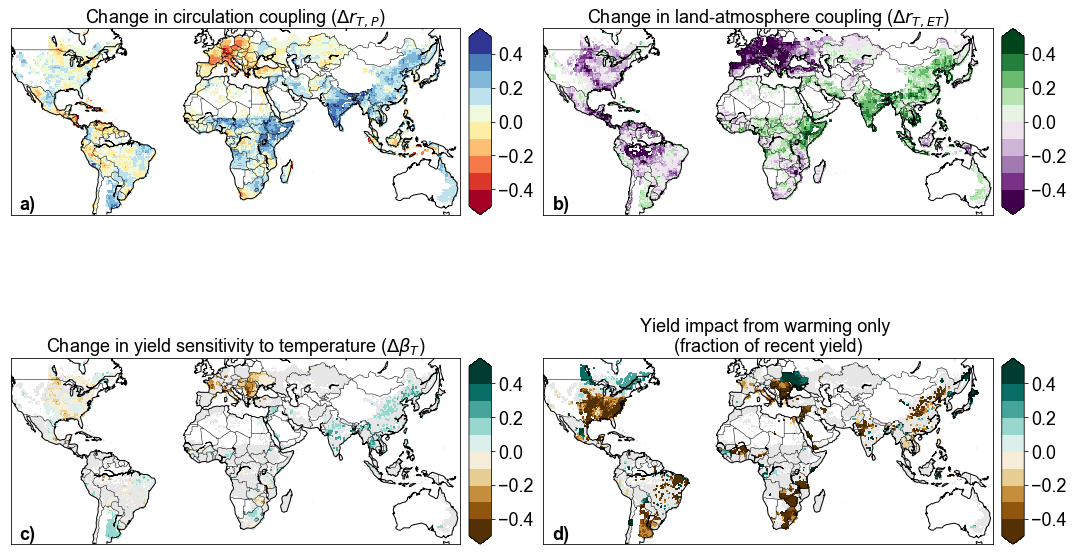

In [44]:
### plot 585 details
from mpl_toolkits.basemap import Basemap
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

crops = ['Maize']
var = [delRtpPctl*~np.isnan(coefs[c]['bstd_temp']),delRtetPctl*~np.isnan(coefs[c]['bstd_temp']),betaprime*~np.isnan(coefs[c]['bstd_temp']),delY/meanY*~np.isnan(coefs[c]['bstd_temp'])]
titles = ['Change in circulation coupling ' + r'($\Delta r_{T,P}$)','Change in land-atmosphere coupling ' + r'($\Delta r_{T,ET}$)','Change in yield sensitivity to temperature ' + r'($\Delta\beta_{T}$)','Yield impact from warming only \n(fraction of recent yield)']



cmaps = [mpl.cm.RdYlBu,mpl.cm.PRGn, mpl.cm.BrBG,mpl.cm.BrBG]


pThrsh = 0.1

var1 = coefs[c]['p_temp']>=0.1

fig,axs = plt.subplots(2,2)
fig.set_size_inches(15,12)
let = ['a)','b)','c)','d)']

for i,ax in enumerate(axs.reshape(-1)):
    
    var0 = var[i]
    var0[np.isnan(coefs[c]['bstd_temp'])] = np.nan

    cmap1 = cmaps[i]
    bounds=np.arange(-.5,.51,.1)
    norm1 = mpl.colors.BoundaryNorm(bounds,cmap1.N)
    
    if i>1:
        var0[~pmask] = np.nan

    m = Basemap(projection='merc',llcrnrlat=-42,urcrnrlat=57,llcrnrlon=-125,urcrnrlon=155)
    map=m.pcolor(lonGrid,latGrid,var1,latlon=True,vmin=0,vmax=10,cmap='binary',ax=ax) 
    map=m.pcolor(lonGrid,latGrid,var0,latlon=True,vmin=-0.5,vmax=0.5,cmap=cmap1,norm=norm1,ax=ax)
    m.drawcoastlines(ax=ax);m.drawcountries(ax=ax);
    #m.colorbar(map,ax=ax)
    
    cb=m.colorbar(map,extend='both',ax=ax)
    cb.ax.tick_params(labelsize=18)
    #cb.ax.set_yticklabels(['',-0.4,'',-0.2,'',0,'',0.2,'',0.4])
    #lonStpl,latStpl = m(lonGrid[pvals<pThrsh],latGrid[pvals<pThrsh]); 
    #m.plot(lonStpl,latStpl,color='gray',marker='|',linestyle='',markersize=.3)
    ax.text(0.02,0.025,let[i],transform=ax.transAxes,fontsize=18,fontweight='bold')

    ax.set_title(titles[i],fontsize=18)

plt.tight_layout(pad=0.6)
fig.subplots_adjust(bottom=0.13)

# cbar_ax = fig.add_axes([0.05, 0.08, 0.9, 0.03])
# cb=fig.colorbar(map, cax=cbar_ax,orientation='horizontal',extend='both')
# cb.ax.tick_params(labelsize=18)



#cb.set_label(r'r(T,ET)',fontsize=24)

#plt.savefig('projections_fig_'+scen+'_'+str(pctl)+'pctile.pdf')    

### Step 6: plot Fig's 4-5

In [4]:
#set scenario
scen = 'ssp245'

C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\mpl_toolkits\basemap\__init__.py:3360: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\mpl_toolkits\basemap\__init__.py:3399: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


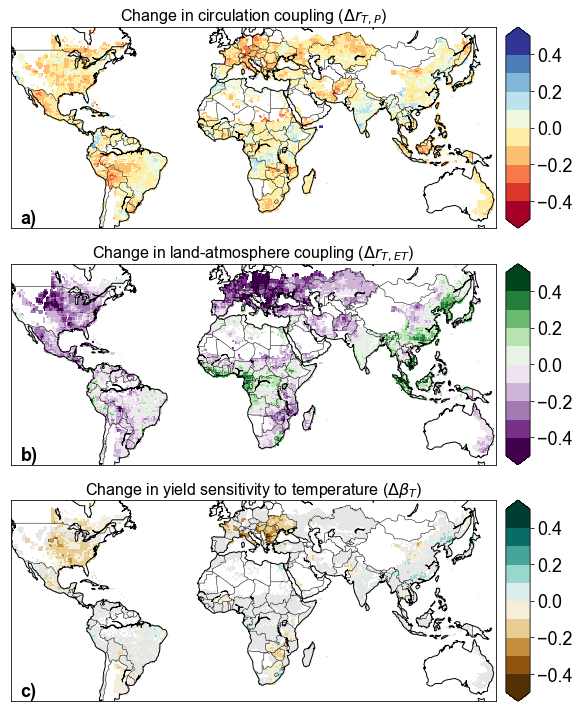

In [51]:
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

sacksDir = '..\\data\\SacksData\\0.5d\\'
sacks = Dataset(sacksDir + '\\Maize.crop.calendar.fill.nc','r')    
lon = sacks['longitude'][:]
lat = sacks['latitude'][:]
lons = lon
lats = lat
lonGrid,latGrid=np.meshgrid(lons,lats)

var = [delRtpPctl*~np.isnan(coefs[c]['bstd_temp']),delRtetPctl*~np.isnan(coefs[c]['bstd_temp']),betaprime*~np.isnan(coefs[c]['bstd_temp'])]
titles = ['Change in circulation coupling ' + r'($\Delta r_{T,P}$)','Change in land-atmosphere coupling ' + r'($\Delta r_{T,ET}$)',\
          'Change in yield sensitivity to temperature ' + r'($\Delta\beta_{T}$)'] #$t$ $ha^{-1}$ $K^{-1}$
let = ['a)','b)','c)']
pmask = coefs[c]['p_temp'] < 0.1

cmaps = [mpl.cm.RdYlBu,mpl.cm.PRGn, mpl.cm.BrBG]

fig,axs = plt.subplots(3,1,figsize=(10,10))

for i,ax in enumerate(axs):
    
    var0 = var[i]
    var0[np.isnan(coefs[c]['bstd_temp'])] = np.nan
    
    if i==2:
        var0[~pmask] = np.nan

    cmap1 = cmaps[i]
    bounds=[-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5]
    norm1 = mpl.colors.BoundaryNorm(bounds,cmap1.N)
    
    m = Basemap(projection='merc',llcrnrlat=-42,urcrnrlat=57,llcrnrlon=-125,urcrnrlon=155)
    map=m.pcolor(lonGrid,latGrid,var1,latlon=True,vmin=0,vmax=10,cmap='binary',ax=ax) 
    map=m.pcolor(lonGrid,latGrid,var0,latlon=True,vmin=-0.5,vmax=0.5,cmap=cmap1,norm=norm1,ax=ax) 
    m.drawcoastlines();m.drawcountries();#m.drawlsmask(ocean_color = 'blue', land_color='0.95')
    cb=m.colorbar(map,extend='both',ax=ax)
    cb.ax.tick_params(labelsize=18)
    #cb.set_label('Percent of recent yield',fontsize=16)
    ax.text(0.02,0.025,let[i],transform=ax.transAxes,fontsize=18,fontweight='bold')
    ax.set_title(titles[i],fontsize=16) # ($\Delta\Delta$Y, $t$ $ha^{-1}$)'
    
plt.tight_layout()

C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater_equal
C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater_equal
C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\mpl_toolkits\basemap\__init__.py:3360: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\mpl_toolkits\basemap\__init__.py:3399: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


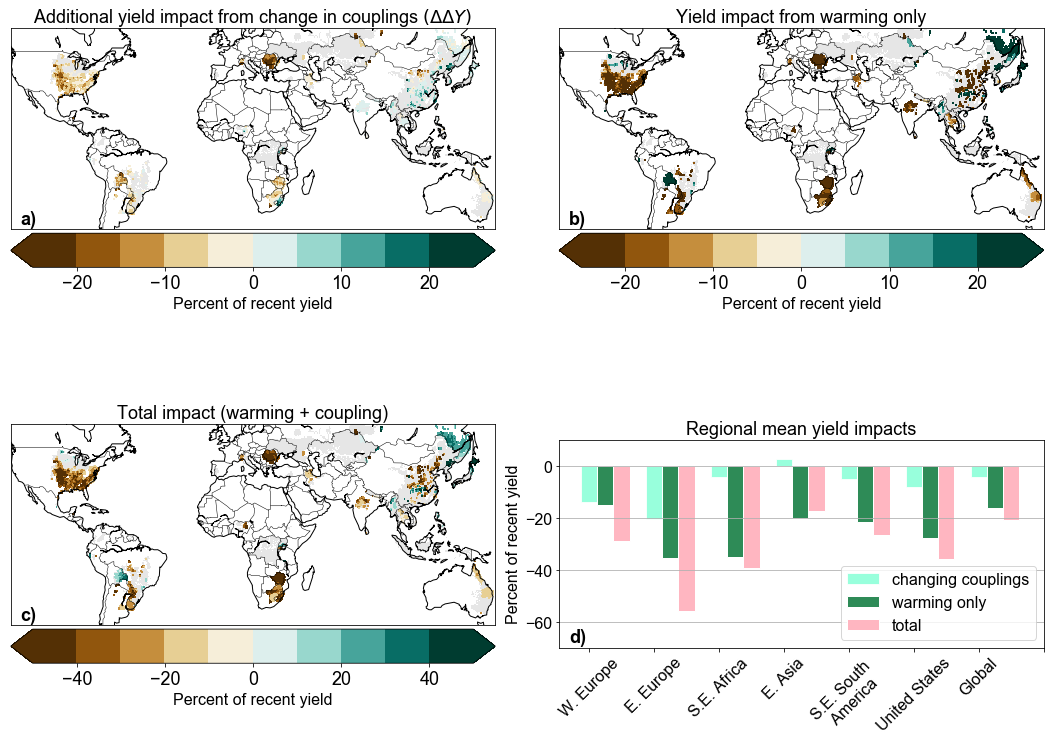

In [36]:
from mpl_toolkits.basemap import Basemap
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

var = [deldelY/meanY*~np.isnan(coefs[c]['bstd_temp']),delY/meanY*~np.isnan(coefs[c]['bstd_temp']),delY/meanY*~np.isnan(coefs[c]['bstd_temp'])+deldelY/meanY*~np.isnan(coefs[c]['bstd_temp'])]
titles = ['Additional yield impact from change in couplings ' + r'$(\Delta\Delta{Y})$',\
          'Yield impact from warming only','Total impact (warming + coupling)']

pmask = coefs[c]['p_temp'] < 0.1

cmap1 = mpl.cm.BrBG
bounds=np.arange(-25,25.01,5)
norm1 = mpl.colors.BoundaryNorm(bounds,cmap1.N)

crops = ['Maize']


lonGrid,latGrid=np.meshgrid(lons,lats)

pThrsh = 0.1

fig,axs = plt.subplots(2,2)
fig.set_size_inches(15,12)
let = ['a)','b)','c)','d)']

for i,ax in enumerate(axs.reshape(-1)[:-1]):
            
    var0 = var[i]
    var0[np.isnan(coefs[c]['bstd_temp'])] = np.nan
    var0[coefs[c]['p_temp']>=0.1] = np.nan

    var1 = coefs[c]['p_temp']>=0.1
    
    if i == 2:
        cmap1 = mpl.cm.BrBG
        bounds=np.arange(-50,50.01,10)
        norm1 = mpl.colors.BoundaryNorm(bounds,cmap1.N)
        
    #latGrid = latGrid[::-1,:]
    m = Basemap(projection='merc',llcrnrlat=-42,urcrnrlat=57,llcrnrlon=-125,urcrnrlon=155)
    map=m.pcolor(lonGrid,latGrid,var1,latlon=True,vmin=0,vmax=10,cmap='binary',ax=ax) 
    map=m.pcolor(lonGrid,latGrid,var0*100,latlon=True,vmin=-50,vmax=50,cmap=cmap1,norm=norm1,ax=ax) 
    m.drawcoastlines(ax=ax);m.drawcountries(ax=ax);#m.drawlsmask(ocean_color = 'blue', land_color='0.95')
    cb=m.colorbar(map,extend='both',size='17%',ax=ax,location='bottom')
    cb.ax.tick_params(labelsize=18)
    cb.set_label('Percent of recent yield',fontsize=16)
    #m.colorbar(map,ax=ax)

    #lonStpl,latStpl = m(lonGrid[pvals<pThrsh],latGrid[pvals<pThrsh]); 
    #m.plot(lonStpl,latStpl,color='gray',marker='|',linestyle='',markersize=.3)
    ax.text(0.02,0.025,let[i],transform=ax.transAxes,fontsize=18,fontweight='bold')

    ax.set_title(titles[i],fontsize=18)

### panel d

ax=axs[1][1]

regions = {'W. Europe':[35,55,-10,15],
           'E. Europe':[35,55,15,40],
           'S.E. Africa':[-30,-5,10,45], 
          'E. Asia':[9,47,98,131],
          'S.E. South America':[-39,-20,-65,-44],
           'United States':[29,49,-124,-69],
           'Global':[-89,89,-179,179]
          }

deldelYregl = {}
delYregl = {}
ddYmax = {}
ddYmin = {}

for r,region in enumerate(regions):
    regMsk = (latGrid>regions[region][0])&(lonGrid>regions[region][2])&(latGrid<regions[region][1])&(lonGrid<regions[region][3])
    matholder=deldelY/meanY*100
    matholder[pmask==0]=np.nan
    matholder[regMsk==0]=np.nan
    deldelYregl[region] = np.nanmean(matholder)
    matholder=delY/meanY*100
    matholder[pmask==0]=np.nan
    matholder[regMsk==0]=np.nan
    delYregl[region] = np.nanmean(matholder)
    ddYmax[region] = np.nanmax(matholder)
    ddYmin[region] = np.nanmin(matholder)

labs=list(deldelYregl.keys())
bw = 0.25

tot = np.array([i for i in delYregl.values()])+np.array([i for i in deldelYregl.values()])

bdeldel = ax.bar(np.arange(len(labs)),deldelYregl.values(),width=bw,edgecolor='white',color='aquamarine',alpha=0.8)
bdel = ax.bar(np.arange(len(labs))+bw,delYregl.values(),width=bw,edgecolor='white',color='seagreen')
btot = ax.bar(np.arange(len(labs))+2*bw,tot,width=bw,edgecolor='white',color='lightpink')

ax.set_xticklabels(labs)

ax.set_title('Regional mean yield impacts',fontsize=18)
ax.grid(axis='y')
# ax.set_xlim(0,18)
# ax.set_ylim(-55,59)
ax.set_xticks(np.arange(len(labs)+bw))
labs[-3] = 'S.E. South \n America '
ax.set_xticklabels(labs,rotation=45,fontsize=16)
ax.set_ylabel('Percent of recent yield',fontsize=16)   
ax.tick_params(axis='y',labelsize=16)
ax.legend([bdeldel,bdel,btot],['changing couplings','warming only','total'],fontsize=16)
#ax.plot([1,2,3],[1,2,3])
ax.set_ylim(-70,10)
ax.set_aspect(0.04,'box')
ax.text(0.02,0.025,'d)',transform=ax.transAxes,fontsize=18,fontweight='bold')

plt.tight_layout(pad=0.5)

#panel d
# fig.subplots_adjust(bottom=0.13)

# cbar_ax = fig.add_axes([0.05, 0.08, 0.9, 0.03])
# cb=fig.colorbar(map, cax=cbar_ax,orientation='horizontal')
# cb.ax.tick_params(labelsize=18)


***
### Step 7: compute model agreement on sign, plot Fig. 6

In [29]:
deldelYregl

{'E. Asia': 3.2513230664684785,
 'E. Europe': -24.028991523407239,
 'Global': -4.9782727308547541,
 'S.E. Africa': -5.1171046879302597,
 'S.E. South America': -5.7849220225572742,
 'United States': -9.1376693068822981,
 'W. Europe': -16.086124477382814}

In [26]:

#compute model-specific changes for the ensemble
c="Maize"
meanDeldelY = np.empty(len(models))
meanDeldelP = np.empty(len(models))
deldelYmat = np.empty((360,720,len(models)))

for m,mod in enumerate(models):

    #compute change in beta T
    betaprime = a1*deltaRtet[c][:,:,m] + a2*deltaRtp[c][:,:,m]

    #### compute yield impact 
    deldelYmat[:,:,m] = sigmaY/sigmaT*betaprime*deltaTmmm #units t ha-1
    
    #compute global mean
    meanDeldelY[m] = np.nanmean(deldelYmat[:,:,m][pmask]/meanY[pmask])
    meanDeldelP[m] = np.nansum(deldelYmat[:,:,m][pmask]*meanA[pmask])
    
if scen == 'ssp245':
    meanDeldelY245 = meanDeldelY
    meanDeldelP245 = meanDeldelP
    deldelYmat245 = deldelYmat
if scen == 'ssp585':
    meanDeldelY585 = meanDeldelY
    meanDeldelP585 = meanDeldelP
    deldelYmat585 = deldelYmat

In [ ]:


regions = {'W. Europe':[35,55,-10,15],
           'E. Europe':[35,55,15,40],
           'S.E. Africa':[-22,-5,22,41], 
          'E. Asia':[9,47,98,131],
          'S.E. South America':[-39,-20,-65,-44],
           'United States':[29,49,-124,-69]
          }

deldelYregl245 = {}
deldelYregl585 = {}


for r,region in enumerate(regions):
    regMsk = (latGrid>regions[region][0])&(lonGrid>regions[region][2])&(latGrid<regions[region][1])&(lonGrid<regions[region][3])
    deldelYregl245[region] = []
    deldelYregl585[region] = []
    
    for m,mod in enumerate(models):
        
        matholder245=deldelYmat245[:,:,m]/meanY*100
        matholder245[pmask==0]=np.nan
        matholder245[regMsk==0]=np.nan
        matholder585=deldelYmat585[:,:,m]/meanY*100
        matholder585[pmask==0]=np.nan
        matholder585[regMsk==0]=np.nan
        deldelYregl245[region].append(np.nanmean(matholder245))   #np.nanmean((deldelYmat245[:,:,m][pmask]/meanY[pmask])*regMsk[pmask])*100)
        deldelYregl585[region].append(np.nanmean(matholder585))


colors=['darkturquoise','coral']

for r,region in enumerate(regions):
    bp = plt.boxplot([deldelYregl245[region],deldelYregl585[region]],positions = [r+2*r+1,r+2*r+2],widths=0.6,patch_artist=True,medianprops=dict(color='black'))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

ax.grid(axis='y')
ax.set_xlim(0,18)
ax.set_ylim(-55,59)
ax.set_xticks(np.arange(1.5,18,3))
labs=list(deldelYregl245.keys())
labs[-2] = 'S.E. South \n America '
ax.set_xticklabels(labs,rotation=45)
ax.set_ylabel('Additional yield change (%)')   
ax.hlines(0,0,18)
#ax.legend(['SSP2-4.5','SSP5-8.5'])

C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less
C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less
C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\mpl_toolkits\basemap\__init__.py:3360: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\HAL 9

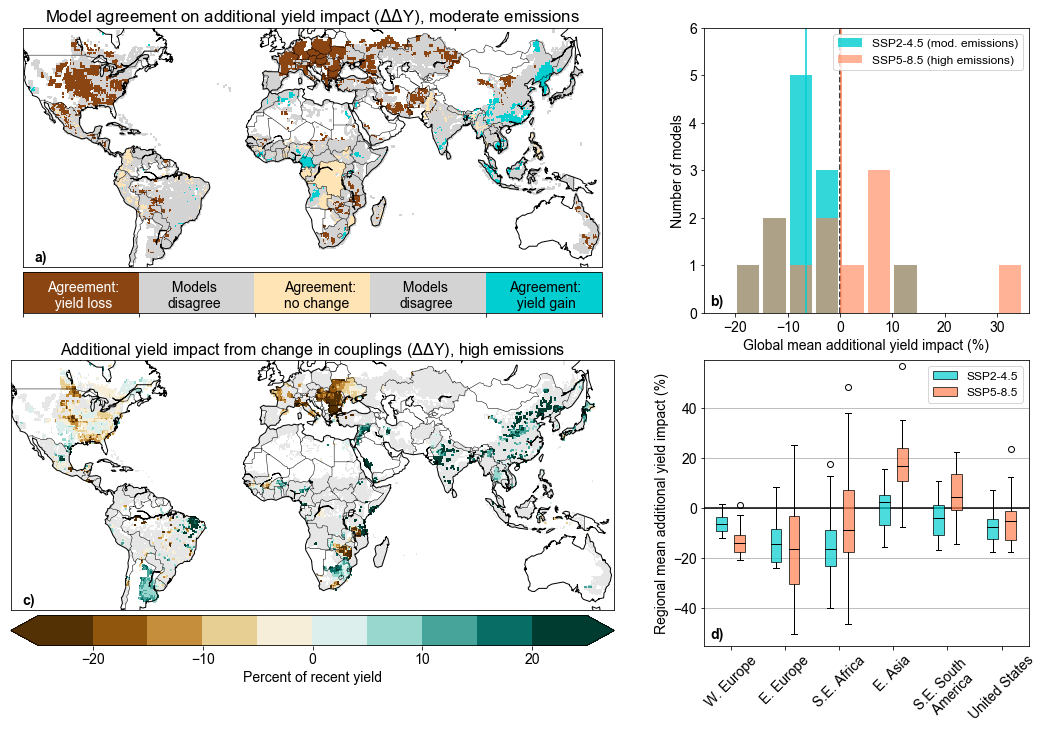

In [34]:
#### fig 6
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from matplotlib import colors
from mpl_toolkits.basemap import Basemap

plt.rcParams['font.size'] = 14
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

axs = []
fig = plt.figure(figsize=(15,10))
spec = gridspec.GridSpec(ncols=3, nrows=2)
axs.append(fig.add_subplot(spec[0, 0:2]))
axs.append(fig.add_subplot(spec[0, 2]))
axs.append(fig.add_subplot(spec[1, 0:2]))
axs.append(fig.add_subplot(spec[1, 2]))




#### a: model agreement
nmodsign = np.empty((360,720))
nmod0 = np.empty((360,720))

#compute model agreement
for i in range(360):
    for j in range(720):
        nmodpos = np.sum(deldelYmat245[i,j,:]>0.1)
        nm0 = np.sum((deldelYmat245[i,j,:]<0.1)&(deldelYmat245[i,j,:]>-0.1))
        if nmodpos>=8:
            nmodsign[i,j]=nmodpos
            continue
        elif np.sum(deldelYmat245[i,j,:]<-0.1) >=8:
            nmodsign[i,j]=-np.sum(deldelYmat245[i,j,:]<-0.1)
        elif nm0 >= 8:
            nmodsign[i,j] = 0
        else:
            nmodsign[i,j]=5
        
nmodsign[np.isnan(coefs[c]['bstd_temp'])] = np.nan

cols=['saddlebrown','lightgray','moccasin', 'lightgray','darkturquoise']#['saddlebrown','sandybrown','snow', 'snow','snow', 'snow','lightcyan','darkturquoise']
cmap = colors.ListedColormap(cols)
bounds=[-12,-8,-3,3,8,12]
norm = colors.BoundaryNorm(bounds, cmap.N)

ax=axs[0]
m = Basemap(projection='merc',llcrnrlat=-42,urcrnrlat=57,llcrnrlon=-125,urcrnrlon=155)
map=m.pcolor(lonGrid,latGrid,nmodsign,cmap=cmap,norm=norm,latlon=True,ax=ax) 
m.drawcoastlines(ax=ax);m.drawcountries(ax=ax);
ax.text(0.02,0.025,'a)',transform=ax.transAxes,fontsize=14,fontweight='bold')
#ax.text(0.7,0.025,'Moderate emissions',transform=ax.transAxes,fontsize=14)
ax.set_title('Model agreement on additional yield impact ($\Delta\Delta$Y), moderate emissions')
cb= m.colorbar(map,ticks=bounds,size='17%',location='bottom',ax=ax)
#cb.ax.aspect=8
cb.ax.set_xticklabels([],fontsize=18)
cb.ax.set_xticks([])
#cb.set_label('Model agreement on yield change',fontsize=14)
cb.ax.text(0.84,0.13,'Agreement: \n  yield gain')
cb.ax.text(0.04,0.13,'Agreement: \n  yield loss',color='white')
cb.ax.text(0.25,0.13,' Models \ndisagree')
cb.ax.text(0.65,0.13,' Models \ndisagree')
cb.ax.text(0.45,0.13,'Agreement: \nno change')


#### b: histgram of global
ax=axs[1]
#plt.hist([meanDeldelY245*100,meanDeldelY585*100],color = ['mediumturquoise','coral'],bins=np.arange(-50,41,5),rwidth=0.85)
ax.hist([meanDeldelY245*100],color = 'darkturquoise',alpha=0.8,bins=np.arange(-50,41,5),rwidth=0.85)
ax.hist([meanDeldelY585*100],color = 'coral',alpha=0.6,bins=np.arange(-50,41,5),rwidth=0.85)

ax.set_ylabel('Number of models')
ax.set_xlabel('Global mean additional yield impact (%)')
ax.legend(['SSP2-4.5 (mod. emissions)','SSP5-8.5 (high emissions)'],fontsize=12)#,loc='upper left')
ax.vlines(0,ymin=0,ymax=7,linestyle='--')
ax.vlines(100*np.median(meanDeldelY245),ymin=0,ymax=7,color='darkturquoise')
ax.vlines(100*np.median(meanDeldelY585),ymin=0,ymax=7,color='coral')
ax.set_ylim((0,6))
ax.set_xticks(np.arange(-50,41,10))
ax.set_xlim((-26,36))
ax.text(0.02,0.025,'b)',transform=ax.transAxes,fontsize=14,fontweight='bold')

### c: 585 additional yield impact
ax=axs[2]
var0 =deldelY585/meanY*100
var0[np.isnan(coefs[c]['bstd_temp'])] = np.nan
var0[coefs[c]['p_temp']>=0.1] = np.nan
var1 = coefs[c]['p_temp']>=0.1

cmap1 = mpl.cm.BrBG
bounds=np.arange(-25,25.01,5)
norm1 = mpl.colors.BoundaryNorm(bounds,cmap1.N)

m = Basemap(projection='merc',llcrnrlat=-42,urcrnrlat=57,llcrnrlon=-125,urcrnrlon=155)
map=m.pcolor(lonGrid,latGrid,var1,latlon=True,vmin=0,vmax=10,cmap='binary',ax=ax) 
map=m.pcolor(lonGrid,latGrid,var0,latlon=True,vmin=-25,vmax=25,ax=ax,norm=norm1,cmap=cmap1) 
m.drawcoastlines(ax=ax);m.drawcountries(ax=ax);
#cb=m.colorbar(map)
#cb.ax.tick_params(labelsize=14)
#ax.set_aspect(1.3,'box')
cb= m.colorbar(map,size='12%',location='bottom',ax=ax,extend='both')
cb.set_label('Percent of recent yield',fontsize=14)
ax.text(0.02,0.025,'c)',transform=ax.transAxes,fontsize=14,fontweight='bold')
ax.set_title(r'Additional yield impact from change in couplings ($\Delta\Delta$Y), high emissions',fontsize=16) # ($\Delta\Delta$Y, $t$ $ha^{-1}$)'


### d: regional
ax=axs[3]
regions = {'W. Europe':[35,55,-10,15],
           'E. Europe':[35,55,15,40],
           'S.E. Africa':[-22,-5,22,41], 
          'E. Asia':[9,47,98,131],
          'S.E. South America':[-39,-20,-65,-44],
           'United States':[29,49,-124,-69]
          }

deldelYregl245 = {}
deldelYregl585 = {}


for r,region in enumerate(regions):
    regMsk = (latGrid>regions[region][0])&(lonGrid>regions[region][2])&(latGrid<regions[region][1])&(lonGrid<regions[region][3])
    deldelYregl245[region] = []
    deldelYregl585[region] = []
    
    for m,mod in enumerate(models):
        
        matholder245=deldelYmat245[:,:,m]/meanY*100
        matholder245[pmask==0]=np.nan
        matholder245[regMsk==0]=np.nan
        matholder585=deldelYmat585[:,:,m]/meanY*100
        matholder585[pmask==0]=np.nan
        matholder585[regMsk==0]=np.nan
        deldelYregl245[region].append(np.nanmean(matholder245))   #np.nanmean((deldelYmat245[:,:,m][pmask]/meanY[pmask])*regMsk[pmask])*100)
        deldelYregl585[region].append(np.nanmean(matholder585))


colors=['darkturquoise','coral']

for r,region in enumerate(regions):
    bp = ax.boxplot([deldelYregl245[region],deldelYregl585[region]],positions = [r+2*r+1,r+2*r+2],widths=0.6,patch_artist=True,medianprops=dict(color='black'))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

ax.grid(axis='y')
ax.set_xlim(0,18)
ax.set_ylim(-55,59)
ax.set_xticks(np.arange(1.5,18,3))
labs=list(deldelYregl245.keys())
labs[-2] = 'S.E. South \n America '
ax.set_xticklabels(labs,rotation=45)
ax.set_ylabel('Regional mean additional yield impact (%)')   
ax.hlines(0,0,18)
ax.legend(bp['boxes'][0:2],['SSP2-4.5','SSP5-8.5'],fontsize=12)
ax.text(0.02,0.025,'d)',transform=ax.transAxes,fontsize=14,fontweight='bold')


plt.tight_layout(pad=0.1)

### plot SI Fig 3

C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\mpl_toolkits\basemap\__init__.py:3360: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\HAL 9000\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\mpl_toolkits\basemap\__init__.py:3399: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


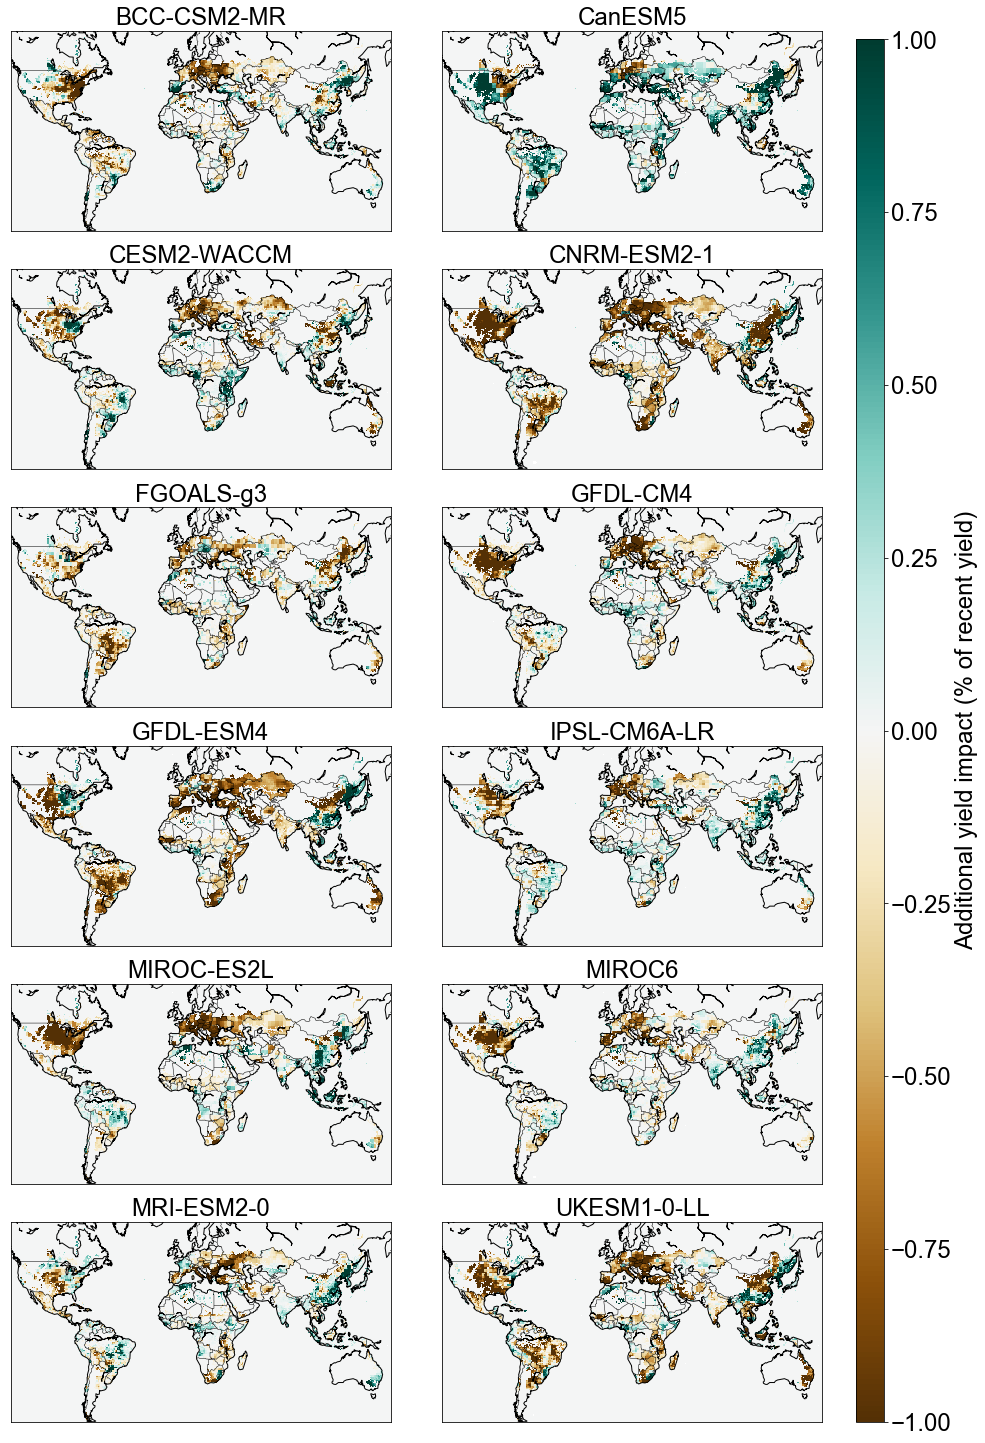

In [19]:
#plot individual models
from mpl_toolkits.basemap import Basemap
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"


fig,axs = plt.subplots(6,2)
fig.set_size_inches(13,20)

for i,ax in enumerate(axs.reshape(-1)):
    var = deldelYmat245[:,:,i]#/meanY
    m = Basemap(projection='merc',llcrnrlat=-55,urcrnrlat=65,llcrnrlon=-130,urcrnrlon=160,ax=ax)
    map=m.pcolor(lonGrid,latGrid,var,cmap='BrBG',latlon=True,vmin=-1,vmax=1,ax=ax) 
    m.drawcoastlines();m.drawcountries();ax.set_title(models[i],fontsize=24)

plt.tight_layout()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.95, 0.01, 0.03, 0.96])
cb=fig.colorbar(map, cax=cbar_ax)
cb.ax.tick_params(labelsize=24)
cb.set_label('Additional yield impact (% of recent yield)',fontsize=24)

***
### In case Google cloud API doesn't work, you can access CMIP6 Using ESGF search api + opendap 

In [1]:

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as Dataset

from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)


In [3]:
scen = 'ssp245'
var = 'evspsbl'

result = esgf_search(activity_id='ScenarioMIP', table_id='Amon', variable_id='evspsbl', experiment_id='ssp245',
                  member_id="r1i1p1f1")

#for i,u in enumerate(result):
inst = list()
for i,u in enumerate(result):
    substr = u[u.find('MIP/')+4:]
    inst.append(substr[:substr.find('/')])
    


institutions = np.unique(np.array(inst))

mods = list()
for i in institutions:
    result = esgf_search(activity_id='ScenarioMIP', table_id='Amon', variable_id='evspsbl', experiment_id='ssp245',
                  member_id="r1i1p1f1",institution_id = i)
    for r in result:
        substr = r[r.find(i):]
        substr = substr[substr.find('/')+1:]
        mods.append(substr[:substr.find('/')])

models = np.unique(np.array(mods))


https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=evspsbl&experiment_id=ssp245&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=evspsbl&experiment_id=ssp245&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=evspsbl&experiment_id=ssp245&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=evspsbl&experiment_id=ssp245&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=evsps

In [5]:
result = esgf_search(activity_id='ScenarioMIP', table_id='Amon', variable_id='evspsbl', experiment_id='ssp245',
                  member_id="r1i1p1f1",source_id = 'AWI-CM-1-1-MR')

ds = xr.open_mfdataset(result, combine='by_coords')
ds